# 1. SAM2-based Wire Segmentation

In [27]:
import sys
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
###############################
MainFolder = "/home/worker/Env"
###############################

os.chdir(MainFolder) 
print(f"[INFO] Working directory set to: {os.getcwd()}")
sys.path.append(Path(MainFolder) / "Input_Video")

[INFO] Working directory set to: /home/worker/Env


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
np.random.seed(3)
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [4]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = Path(MainFolder) / "sam2/checkpoints/sam2.1_hiera_large.pt" 
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml" 
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

1) Image(JPG)

In [5]:

# from PIL import Image
# image = Image.open('Your/path')
# width, height = image.size
# image_width = width
# image_height = height
# predictor.set_image(image)
# input_point = np.array([[image_width/2, image_height/2]])
# input_label = np.array([1])
# image = np.array(image.convert("RGB"))

2. Image(PNG)

In [6]:
# from PIL import Image
# import numpy as np

# image_path = 'Your/path'
# image = Image.open(image_path)

# width, height = image.size
# image_width = width
# image_height = height

# image_np = np.array(image.convert("RGB"))

# predictor.set_image(image_np)

# input_point = np.array([[image_width / 2, image_height / 2]])
# input_label = np.array([1])

# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# show_points(input_point, input_label, plt.gca())
# plt.axis('on')
# plt.show()  

# masks, scores, logits = predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     multimask_output=False,
# )
# sorted_ind = np.argsort(scores)[::-1]
# masks = masks[sorted_ind]
# scores = scores[sorted_ind]
# logits = logits[sorted_ind]
# show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

3) Video

In [7]:
import cv2
from PIL import Image

MainFolder = "/home/worker/Env/DongDong/10월논문"
 
video_path =  Path(MainFolder) / '1_Dataset_Video/Experiment_input.mp4'
save_path =  Path(MainFolder) / '2_First_Frame/First_Frame_RGB.png'

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if ret:
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    image.save(save_path)
    print(f"The first frame has been saved: {save_path}")
    
    width, height = image.size
    image_width = width
    image_height = height

    image_np = np.array(image.convert("RGB"))
      
    # predictor.set_image(image_np)
    
    input_point = np.array([[image_width / 2, image_height / 2]])
    input_label = np.array([1])

else:
    print("Failed to extract the first frame from the video.")




The first frame has been saved: /home/worker/Env/DongDong/10월논문/2_First_Frame/First_Frame_RGB.png


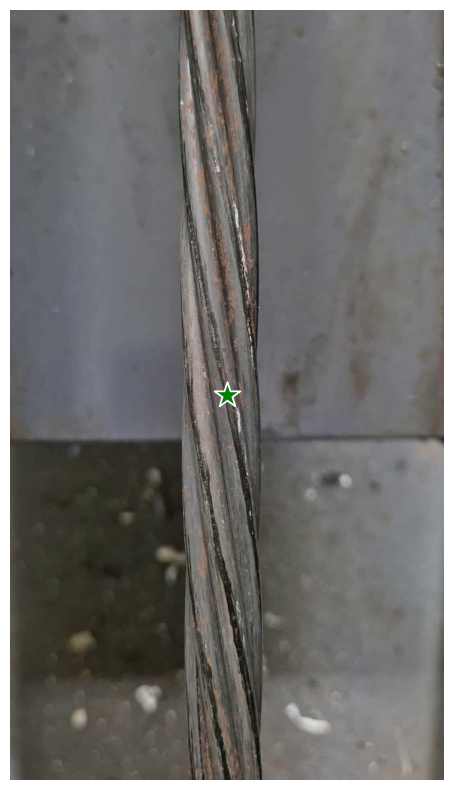

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()  

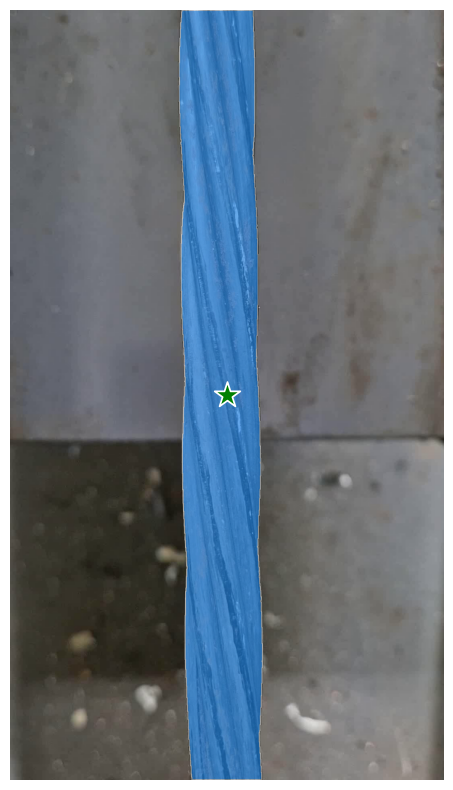

In [9]:
predictor.set_image(image_np)

input_point = np.array([[image_width / 2, image_height / 2]])  
input_label = np.array([1]) 


masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)


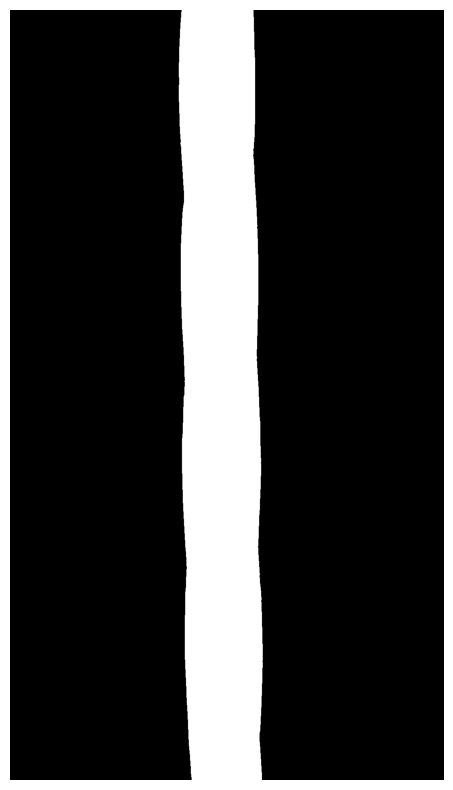

In [10]:
binary_mask = masks[0]
binary_image = (binary_mask * 255).astype(np.uint8)
image = Image.fromarray(binary_image, mode='L')
save_file_path = Path(MainFolder) / '2_Binary/First_Frame_Binary.png' 
image.save(save_file_path)


plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray') 
plt.axis('off')
plt.show()


# 2. Co-tracker

In [11]:
sys.path.append(Path(MainFolder) / "co-tracker3")

In [12]:

import os
import torch
from base64 import b64encode
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from IPython.display import HTML
video = read_video_from_path(video_path)
video = torch.from_numpy(video).permute(0, 3, 1, 2)[None].float()
def show_video(video__path):
    video_file = open(video__path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="640" height="480" autoplay loop controls><source src="{video_url}"></video>""")

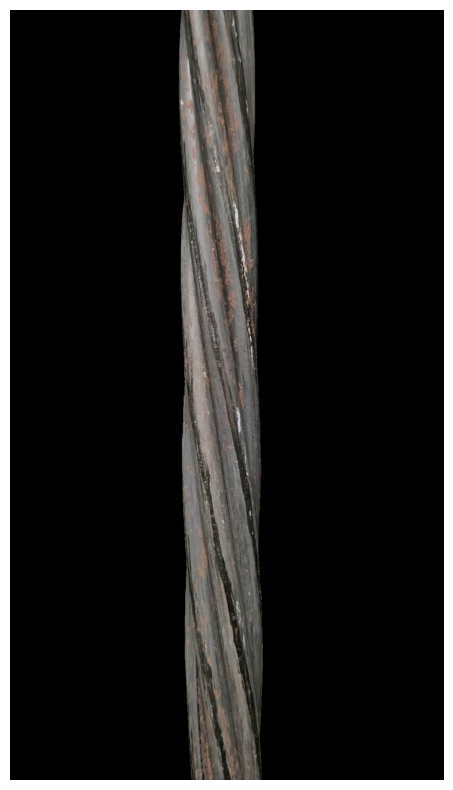

In [13]:
MainFolder = "/home/worker/Env/DongDong/10월논문"
 
input_mask = save_file_path
segm_mask = np.array(Image.open(input_mask))
plt.figure(figsize=(10, 10))
plt.axis('off')  
plt.imshow((segm_mask[...,None]/255.*video[0,0].permute(1,2,0).cpu().numpy()/255.))
output_path = Path(MainFolder) / "2_Binary/overlay_image.png"
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)


In [14]:
from cotracker.predictor import CoTrackerPredictor


model = CoTrackerPredictor(
    checkpoint=os.path.join(
        Path(MainFolder) / 'co-tracker/checkpoints/cotracker2.pth' 
    )
)
if torch.cuda.is_available():
    model = model.cuda()
    video = video.cuda()


In [15]:
grid_size = 200
pred_tracks, pred_visibility = model(video, grid_size=grid_size, segm_mask=torch.from_numpy(segm_mask)[None, None])

vis = Visualizer(
    save_dir=Path(MainFolder) /'Tracker',
    pad_value=5,
    linewidth=2,
    show_first_frame=4,
    fps=1,
    mode = "cool",   
)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='segm_grid_200');

[rawvideo @ 0xd8c28c0] Stream #0: not enough frames to estimate rate; consider increasing probesize
[swscaler @ 0xd8da540] Warning: data is not aligned! This can lead to a speed loss


Video saved to /home/worker/Env/Tracker/segm_grid_200.mp4


In [16]:
show_video(Path(MainFolder) /"Tracker/segm_grid_200.mp4")

In [ ]:
import pandas as pd

frame_distances_all = []


for frame_idx in range(pred_tracks.shape[1] - 1):  #
    current_frame_coords = pred_tracks[0, frame_idx, :, :].cpu().numpy()  
    next_frame_coords = pred_tracks[0, frame_idx + 1, :, :].cpu().numpy()  
    
    distances = np.sqrt(np.sum((next_frame_coords - current_frame_coords) ** 2, axis=1))
    
    if len(distances) > 0:
        mean_distance = np.mean(distances)
        mean_distance = round(mean_distance, 3)
    else:
        mean_distance = np.nan 
    
    frame_distances_all.append({
        'Frame': frame_idx,
        'Mean_Distance': mean_distance
    })

df_all_distances = pd.DataFrame(frame_distances_all)

csv_filename_all_distances = Path(MainFolder) /'3_Csv/all_frame_distances.csv'
df_all_distances.to_csv(csv_filename_all_distances, index=False)


Visualization

In [ ]:
video_path =  Path(MainFolder) /'1_Dataset_Video/Experiment_input.mp4'

first_frame_coords = pred_tracks[0, 0, :, :].cpu().numpy()  
y_min = image_height / 4  
y_max = 3 * image_height / 4  


mask = (first_frame_coords[:, 1] > 0) & (first_frame_coords[:, 1] < image_height)

filtered_pixel_indices = np.where(mask)[0]  

cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_video_path = Path(MainFolder) /'3_Csv/output_filtered_video_with_coordinates.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_idx = 0


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
   
    current_frame_coords = pred_tracks[0, frame_idx, filtered_pixel_indices, :].cpu().numpy()
    

    for coord in current_frame_coords:
        x, y = int(coord[0]), int(coord[1])
    
        cv2.circle(frame, (x, y), 3, (255, 0, 0), -1)

    out.write(frame)

    frame_idx += 1

cap.release()
out.release()

output_video_path  


PosixPath('/home/worker/Env/DongDong/10월논문/3_Csv/output_filtered_video_with_coordinates.mp4')

In [20]:

frame_pixel_data = []

for frame_idx in range(pred_tracks.shape[1]):  
    for pixel_idx in range(pred_tracks.shape[2]): 
        coordinates = pred_tracks[0, frame_idx, pixel_idx, :].cpu().numpy()
        frame_pixel_data.append({
            'Frame': frame_idx,
            'Pixel': pixel_idx,
            'x': coordinates[0],
            'y': coordinates[1]
        })

df_pixel_coords = pd.DataFrame(frame_pixel_data)

csv_filename_pixel_coords = Path(MainFolder) /'3_Csv/frame_pixel_coordinates.csv'
df_pixel_coords.to_csv(csv_filename_pixel_coords, index=False)



# 3. LDC: Lightweight Dense CNN for Edge Detection

In [ ]:
sys.path.append(Path(MainFolder) /"LDC")

In [28]:
!python "$MainFolder/LDC/main.py" --choose_test_data=-1 

/opt/anaconda3/envs/dong/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Number of GPU's available: 2
Pytorch version: 2.5.1+cu124
Traceback (most recent call last):
  File "/home/worker/Env/LDC/main.py", line 526, in <module>
    main(args)
  File "/home/worker/Env/LDC/main.py", line 416, in main
    dataset_val = TestDataset(args.input_val_dir,
  File "/home/worker/Env/LDC/dataset.py", line 309, in __init__
    self.data_index = self._build_index()
  File "/home/worker/Env/LDC/dataset.py", line 317, in _build_index
    images_path = os.listdir(self.data_root)
NotADirectoryError: [Errno 20] Not a directory: '/home/worker/Env/LDC/edgedetection/frame_0000.png'
